## Assignment 2 Deep Learning - CNNs

_Magnus Caesar_

In [95]:
import numpy as np
import torch
import torch.utils.data as data
from load_func import load_mnist_func
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns
np.random.seed(42)

### General functions

Below are some useful functions and commands that aren't specific to any one exercise.
1. Loading the data
2. Reformating the data to fit PyTorch
3. compute_loss()
4. train()
5. plot_confusion()

In [97]:
# Load the data
# Inputs "station" vs "laptop" specifies the current machine
X_train, Y_train, X_test, Y_test = load_mnist_func("station")

Poopdogs
Reading MNIST: stationary


In [108]:
# Loading the data into pytorch's domain
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

# Create TensorDataset for sequential data (ex 1)...
train_dataset = data.TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = data.TensorDataset(X_test_tensor, Y_test_tensor)

# ... and for graphic data (ex 2-6)
train_dataset_cnn = data.TensorDataset(X_train_tensor.view(60000, 1, 28, 28), Y_train_tensor)
test_dataset_cnn = data.TensorDataset(X_test_tensor.view(10000, 1, 28, 28), Y_test_tensor)

**compute_loss()**

This is similar to the "compute_loss" function used in lab 2.

In [99]:
def compute_loss(y_pred_1h, input_data, labels):
    """
    y_pred: model(input)
    input_data: input from batch
    labels: labels from batch
    """

    loss = torch.nn.functional.cross_entropy(y_pred_1h, labels)
    acc = (y_pred_1h.argmax(dim=1) == labels.argmax(dim=1)).float().mean() # Check accuracy

    return loss, acc

**train() - for optimizing and getting statistics**

The following function "train" is used for all exercises in the assignment. It not only trains the model but also returns several statistics that can be used for plotting. 

In [130]:
def train(model, traindata, testdata, num_epochs=40, batch_size=100, alpha_lr=0.005, optmzr="sgd", reglz=0):
    """
    Train model.
    Input
        model:              a subclass of torch.nn.Module to be trained
        traindata:          self-explanatory. Must be of type torch.TensorDataset
        testdata:           see above
        num_epochs:         # epochs trained [int]
        batch_size:         # batches [int]
        optmzr:             optimizer. Select 'sgd' or 'adam' [string]
    Returns
        x_axis_train:       torch.arange(correct size)
        x_axis_test:        torch.arange(test size)
        train_costs:        [size 60000 / batches * num_epochs]
        train_accuracies:   [size 60000 / batches * num_epochs]
        test_costs:         [size num_epochs]. Average test cost every epoch
        test_accuracies:    [size num_epochs]. Also average across epoch
        total_time:         Time spent training the network
        avgspeed:           Average time / epoch
    Ex. 
    x_tr, x_te, trc, tra, tec, tac, time, avgspeed = train(model, train_dataset_cnn, test_dataset_cnn)
    """

    
    # Optimizer
    if optmzr == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=alpha_lr, momentum=0)
    
    if optmzr == "adam":
        if reglz: # L2 regularization for Adam optimizer
            optimizer = torch.optim.Adam(model.parameters(), lr=alpha_lr, weight_decay=1e-5) # Standard parameters in Adam
        else:
            optimizer = torch.optim.Adam(model.parameters(), lr=alpha_lr) # Standard parameters in Adam

    # Load data
    train_loader = data.DataLoader(traindata, batch_size=batch_size, shuffle=True)
    test_loader = data.DataLoader(testdata, batch_size=batch_size)
    
    # Lists for later plotting
    train_costs = []
    train_accuracies = []
    test_costs = []
    test_accuracies = []

    # For time tracking
    starttime = time.time()

    print("Initializing training")

    # Same training structure as from lab 2
    for epoch in range(0, num_epochs):
        model.train()

        temp_costs1 = []
        temp_acc1 = []

        for input_data, labels in train_loader:
            # b[0][0][0] är en bild. Ser bra ut: kan plottas

            # print(b[0].size())
            # "plt.imshow(b[0][0][0])"

            # Training
            y_pred_1h = model(input_data) # Remade the computeloss function in a momentary lapse of reason
            optimizer.zero_grad()
            loss, train_acc = compute_loss(y_pred_1h, input_data, labels)
            loss.backward()
            optimizer.step()

            # Appending training metrics
            temp_costs1.append(loss.item())
            temp_acc1.append(train_acc)

        train_costs.append(np.mean(temp_costs1))
        train_accuracies.append(np.mean(temp_acc1))
            
        # Test metrics
        temp_costs2 = []
        temp_acc2 = []
        
        for input_data, labels in test_loader:
            y_pred_test = model(input_data)
            loss, acc = compute_loss(y_pred_test, input_data, labels)
            temp_costs2.append(loss.item())
            temp_acc2.append(acc)
        
        test_costs.append(np.mean(temp_costs2))
        test_accuracies.append(np.mean(temp_acc2))

        # Time related
        t0 = time.time()
        t_tot = t0-starttime
        avgspeed = t_tot / (epoch+1)
        est_time_remaining = (avgspeed) * (num_epochs - epoch+1)

        # Statistics
        print(f"Epoch {epoch+1} / {num_epochs}:")
        print(f"Current testing loss:      {test_costs[-1]:>10.4f}")
        print(f"Current test accuracy:     {test_accuracies[-1]:>10.2f}")
        print(f"Ellapsed time:             {round(t0 - starttime, 2):>10.2f} seconds.")
        print(f"Estimated time remaining:  {round(est_time_remaining, 2):>10.2f} seconds.")
        print()
    
    # Time related
    t_end = time.time()
    total_time = t_end-starttime
    print(f"Final results:")
    print(f"Total time elapsed: {round(total_time, 3)} s")
    print(f"Average speed: {round(avgspeed, 3)} s / epoch")

    # x-axis for plotting
    x_axis_train = torch.arange(len(train_costs)) # For every actual iteration
    x_axis_test = torch.arange(len(test_costs)) # Average for every epoch

    return x_axis_train, x_axis_test, train_costs, train_accuracies, test_costs, test_accuracies, total_time, avgspeed

**plot_confusion() - more statistics after a model is done training**

In [101]:
def plot_confusion(model, testdata):
    """
    Plot a confusion matrix given a trained model and testdata.
    Inputs
        model: model to predict classes. Should be trained
        testdata: of type TensorDataset (to allow for both sequential and graphic data for CNNs)
    """

    test_loader = data.DataLoader(testdata, batch_size=200) # Get testdata
    
    y_pred = []
    y_true = []

    for input_data, labels in test_loader: 
        # Comes in batches
        output = model(input_data)

        y_pred += output.argmax(dim=1).flatten()
        y_true += labels.argmax(dim=1).flatten()

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")


In [128]:
def plot_learning_curve(model_stats_lists, names):
    """
    Mostly recycled code from assignment 1. Plot a learning curve after training a model.
    Input
        List of outputs from train
    Output
        None
    
    E.g 
        net1 = train(model1, xtrain, xtest)
        net2 = train(model2, xtrain, xtest)
        net3 = train(model3, xtrain, xtest)
        net4 = train(model4, xtrain, xtest)

        plot_learning_curve([net1, net2, net3, net4])

    Indices
        0: x_axis_train
        1: x_axis_test
        2: train_costs
        3: train_accuracies
        4: test_costs
        5: test_accuracies
        6: total_time
        7: avgspeed
    """
    N_models = len(model_stats_lists)
    print(N_models)
    for e in model_stats_lists:
        plt.plot(e[0], e[3], label="Training accuracies")
        plt.plot(e[1], e[5], label="Testing accuracies")


### Exercise 1. Multi-layer fully connected neural network
Implement exactly the same network as for assignment 1.

1. Compare the performance
2. Compare speed
3. Learning curve plot

**Sequential network class**

The first network from assignment 1 is a linear model. The input dimension is 784 (28x28 pixels) and the output dimension is 10. The second network is multilayered. The one I implemented had 2 hidden layers á 100 neurons each, which the same necessary input and output dimensions.

In [ ]:
class SeqNetwork(torch.nn.Module):
    def __init__(self, num_hidden_layers, input_dim=784, output_dim=10, hidden_dim=100):
        super().__init__()
        self.layers = torch.nn.ModuleList([]) # Ska ha lista med lager / moduler

        # If no hidden layers
        if num_hidden_layers == 0: 
            self.layers.append(torch.nn.Linear(input_dim, output_dim, dtype=torch.float32))

        # If hidden layers layers
        # TODO
        # this might have some logic flaws
        else:
            # First layer
            self.layers.append(torch.nn.Linear(input_dim, hidden_dim))
            self.layers.append(torch.nn.ReLU())
            
            # Add extra layers
            for _ in range(num_hidden_layers):
                self.layers.append(torch.nn.Linear(hidden_dim, hidden_dim))
                self.layers.append(torch.nn.ReLU())
            
            self.layers.append(torch.nn.Linear(hidden_dim, output_dim))
        

    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x
        

In [ ]:
seq_model = SeqNetwork(0)

num_epochs = 5
batch_size = 100 # size used in lab1

seq_stats = train(seq_model, train_dataset, test_dataset, num_epochs=num_epochs, batch_size=batch_size)

Initializing training
Epoch 1 / 5:
Current testing loss:          0.9804
Current test accuracy:           0.83
Ellapsed time:                   1.56 seconds.
Estimated time remaining:        9.38 seconds.

Epoch 2 / 5:
Current testing loss:          0.7189
Current test accuracy:           0.85
Ellapsed time:                   2.96 seconds.
Estimated time remaining:        7.41 seconds.

Epoch 3 / 5:
Current testing loss:          0.6107
Current test accuracy:           0.87
Ellapsed time:                   4.35 seconds.
Estimated time remaining:        5.80 seconds.

Epoch 4 / 5:
Current testing loss:          0.5504
Current test accuracy:           0.87
Ellapsed time:                   5.92 seconds.
Estimated time remaining:        4.44 seconds.

Epoch 5 / 5:
Current testing loss:          0.5107
Current test accuracy:           0.88
Ellapsed time:                   7.53 seconds.
Estimated time remaining:        3.01 seconds.

Final results:
Total time elapsed: 7.535 s
Average speed: 

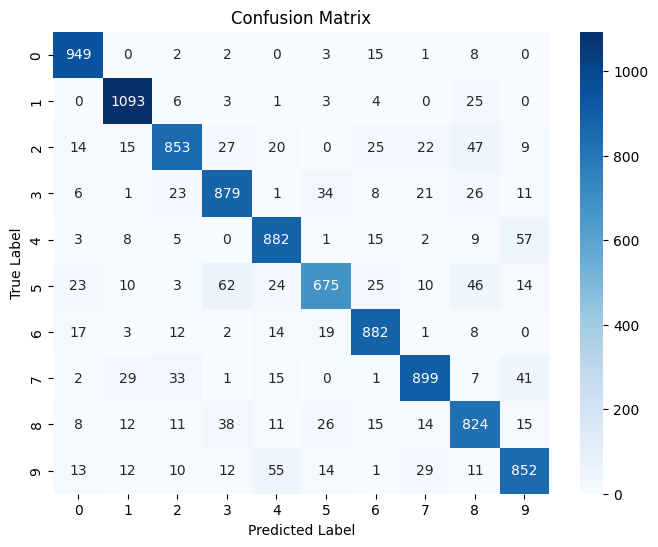

In [ ]:
plot_confusion(seq_model, train_dataset)

### Exercise 2. Multilayer convolutional neural network
CNN using PyTorch with SGD and cross-entropy loss. Reach 98% accuracy.

1. How many learnable weights does the network contain? Compare with previous exercise.
2. Learning curve plot.

**Base class CNN**

In [106]:
class ConvNetwork(torch.nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool2d(2, stride=2)
        self.conv2 = torch.nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        #relu
        #pool
        self.conv3 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        #relu
        self.flatten = torch.nn.Flatten()
        self.fullyconnected = torch.nn.Linear(32*7*7, 10)
        #self.softm = torch.nn.Softmax(dim=1)

        self.components = torch.nn.ModuleList([self.conv1,
                                               self.relu,
                                               self.pool,
                                               self.conv2,
                                               self.relu,
                                               self.pool,
                                               self.conv3,
                                               self.relu,
                                               self.flatten,
                                               self.fullyconnected])
    
    def forward(self, x):

        for l in self.components:
            x = l(x)

        return x

**Optimizing and training**

In [ ]:
model = ConvNetwork()

num_epochs = 30
batch_size = 64 # size used in lab1

trc, tra, tec, tac = train(model, train_dataset_cnn, test_dataset_cnn, num_epochs=num_epochs, batch_size=batch_size)

Entering epoch 1 out of 30.
Current testing loss:          0.6043
Current test accuracy:           0.81
Ellapsed time:                  11.80 seconds.
Estimated time remaining:      365.78 seconds.

Entering epoch 2 out of 30.


KeyboardInterrupt: 

In [ ]:
# Plot: regular learning curve plot of the CNN: see first page of HA2

### Exercise 3: swapping the order of max pooling and the activation function

1. How does this affect the models performance? Final accuracy?
2. Swapping ReLU to tanh: differences? Time taken, final accuarcy?

In [ ]:
class SwapedConvNetwork(torch.nn.Module):
    # Easier to create a new class than to fiddle in the old one
    def __init__(self, activator: str):
        super().__init__()

        # Reused layers
        if activator.lower() == "relu":
            self.activator = torch.nn.ReLU()
        if activator.lower() == "tanh":
            self.activator == torch.nn.Tanh()
        
        self.pool = torch.nn.MaxPool2d(2, stride=2)

        # Full laid out structure
        self.conv1 = torch.nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        # Pool
        # Activator
        self.conv2 = torch.nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        # Pool
        # Activator
        self.conv3 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        # Activator
        self.flatten = torch.nn.Flatten()
        self.fullyconnected = torch.nn.Linear(32*7*7, 10)
        #self.softm = torch.nn.Softmax(dim=1)

        self.components = torch.nn.ModuleList([self.conv1,
                                               self.pool,
                                               self.activator,
                                               self.conv2,
                                               self.pool,
                                               self.activator,
                                               self.conv3,
                                               self.activator,
                                               self.flatten,
                                               self.fullyconnected])
    
    def forward(self, x):

        for l in self.components:
            x = l(x)

        return x



In [ ]:
model = SwapedConvNetwork("relu")

x_train, x_test, trc2, tra2, tec2, tac2, time, avgspeed = train(model, train_dataset_cnn, test_dataset_cnn, batch_size=64, optmzr="sgd")

Entering epoch 1 out of 40.
Current testing loss:          0.4520
Current test accuracy:           0.87
Ellapsed time:                  11.23 seconds.
Estimated time remaining:      460.57 seconds.

Entering epoch 2 out of 40.


KeyboardInterrupt: 

In [ ]:
# Compare with ex2:
# 3a
# Longer or faster training time?
# Final accuracy?
# Learning curve plot: both models next to each other!

# 3b: ReLU -> tanh
# longer or faster training time?
# Final accuracy?
# learning curve plot !

# 3c conclusions?

### Exercise 4: swapping SGD for ADAM

Are good results obtained faster? Compare with SGD; provide learning curve plot.

In [ ]:
model_ex4_sgd = SwapedConvNetwork("relu")
model_ex4_adam = SwapedConvNetwork("relu")

num_epochs = 30

sgd_stats = train(model_ex4_sgd, train_dataset_cnn, test_dataset_cnn, optmzr="sgd")
adam_stats = train(model_ex4_adam, train_dataset_cnn, test_dataset_cnn, optmzr="adam")

Entering epoch 1 out of 40.
Current testing loss:          0.6418
Current test accuracy:           0.80
Ellapsed time:                   9.68 seconds.
Estimated time remaining:      396.79 seconds.

Entering epoch 2 out of 40.


KeyboardInterrupt: 

In [ ]:
# ex4:
# learning curve plot of adam vs sgd here

### Exercise 5: residual connection

Does this improve performance?

Use the same structure as before but replace each conv+act pair with a block of two similar parts with a residual connection over each such block.

So x -> conv1 -> relu = f(x) ==> x -> conv1 -> relu -> conv1 -> relu = g(x) + x 

In [ ]:
class ResidualBlock(torch.nn.Module):
    def __init__(self, channels, activator):
        super().__init__()
        if activator.lower() == "relu":
            self.activator = torch.nn.ReLU()
        if activator.lower() == "tanh":
            self.activator = torch.nn.Tanh()

        self.conv = torch.nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        identity = x  # Save input for residual connection
        out = self.conv(x)
        out = self.activator(out)
        out = self.conv(out)
        out = self.activator(out)
        torch.add(out, identity)
        #out += identity  # Add residual connection. GOOFY AHH CHATGPT DELUSION ! ! !   
        return out

class ResConvNetwork(torch.nn.Module):
    def __init__(self, activator: str):
        super().__init__()

        # Reused layers
        if activator.lower() == "relu":
            self.activator = torch.nn.ReLU()
        if activator.lower() == "tanh":
            self.activator = torch.nn.Tanh()
        
        self.pool = torch.nn.MaxPool2d(2, stride=2)

        self.initial_conv = torch.nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.resblock1 = ResidualBlock(8, "relu") # blir det inte lite konstigt med dimensionerna här?
        
        self.conv2 = torch.nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.resblock2 = ResidualBlock(16, "relu")

        self.conv3 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.resblock3 = ResidualBlock(32, "relu")

        self.flatten = torch.nn.Flatten()
        self.fullyconnected = torch.nn.Linear(32*7*7, 10)

        self.components = torch.nn.ModuleList([self.initial_conv,
                                               self.resblock1,
                                               self.conv2,
                                               self.pool,
                                               self.resblock2,
                                               self.conv3,
                                               self.pool,
                                               self.resblock3,
                                               self.flatten,
                                               self.fullyconnected])
    
    def forward(self, x):
        for l in self.components:
            x = l(x)
        
        return x

In [ ]:
resnet_model = ResConvNetwork("relu")

x_train, x_test, trc2, tra2, tec2, tac2, time, avgspeed = train(resnet_model, train_dataset_cnn, test_dataset_cnn, num_epochs=5, batch_size=64, optmzr="adam")

Initializing training
Epoch 1 / 40:
Current testing loss:          0.0559
Current test accuracy:           0.98
Ellapsed time:                 134.22 seconds.
Estimated time remaining:     5503.15 seconds.

Epoch 2 / 40:
Current testing loss:          0.0349
Current test accuracy:           0.99
Ellapsed time:                 268.08 seconds.
Estimated time remaining:     5361.51 seconds.

Epoch 3 / 40:
Current testing loss:          0.0378
Current test accuracy:           0.99
Ellapsed time:                 402.25 seconds.
Estimated time remaining:     5229.25 seconds.

Epoch 4 / 40:
Current testing loss:          0.0323
Current test accuracy:           0.99
Ellapsed time:                 534.88 seconds.
Estimated time remaining:     5081.39 seconds.



### Exercise 6: CNN with three variations

Todo

1. Swapa SGD mot ADAM och se till att det funkar 
2. Implementera residual connection och kolla vad som sker
3. CNN with three variations:
    1. Regularization
    2. Hur olika djup påverkar träningshastigheten?
    3. Hur olika learning rates påverkar träningshastigheten?

Misc: på något vis få ut x-axel från train() så att man kan plotta flera samtidigt

In [ ]:
standard_adam_cnn_relu = ConvNetwork()  # Base network

standard_adam_cnn_tanh = ConvNetwork() # Compare Adam with ReLU vs Tanh
regularized_adam_cnn = ConvNetwork() # Compare nonregularized vs regularized
higherlr_adam_cnn = ConvNetwork() # Compare with a significantly higher learning rate

xtr = train_dataset_cnn
xte = test_dataset_cnn

net1 = train(standard_adam_cnn_relu, xtr, xte, num_epochs=3, batch_size=64, optmzr="adam")
net2 = train(standard_adam_cnn_tanh, xtr, xte, num_epochs=3, batch_size=64, optmzr="adam")
net3 = train(regularized_adam_cnn, xtr, xte, num_epochs=3, batch_size=64, optmzr="adam", reglz=1)
net4 = train(higherlr_adam_cnn, xtr, xte, num_epochs=3, batch_size=64, alpha_lr=0.02)

names = ["CNN ReLU", "CNN Tanh", "CNN ReLU with regularization", "CNN ReLU with higher LR"]

plot_learning_curve([net1, net2, net3, net4], names)

Initializing training
Epoch 1 / 3:
Current testing loss:          0.0496
Current test accuracy:           0.98
Ellapsed time:                  14.57 seconds.
Estimated time remaining:       58.28 seconds.

Epoch 2 / 3:
Current testing loss:          0.0413
Current test accuracy:           0.99
Ellapsed time:                  29.19 seconds.
Estimated time remaining:       43.78 seconds.

Epoch 3 / 3:
Current testing loss:          0.0332
Current test accuracy:           0.99
Ellapsed time:                  43.44 seconds.
Estimated time remaining:       28.96 seconds.

Final results:
Total time elapsed: 43.44 s
Average speed: 14.48 s / epoch
Initializing training


tensor([   0,    1,    2,  ..., 2811, 2812, 2813])


NameError: name 'names' is not defined

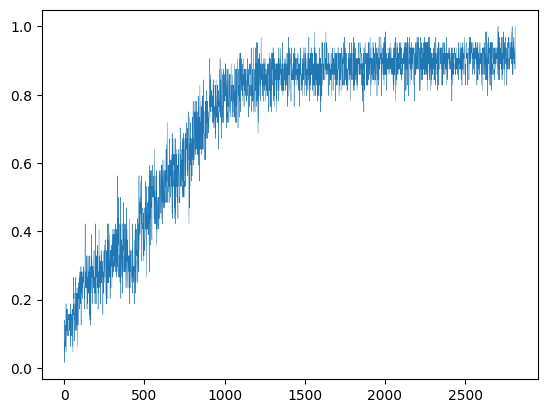

In [129]:
print(net1[0])

plt.plot(net1[0], net1[3], linewidth=0.3)

plot_learning_curve([net1, net2, net3, net4], names)